# Рекомендательные системы
## Описание
Работадель хочет увеличить средний чек продаж. Ключом к успеху будут качественные рекомендации на сайте. Чем лучше мы сможем рекомендовать товар пользователю, тем чаще он будет добавлять товары в корзину. Простая логика, если пользователю нравится товар, он его добавляет в корзину -> средний чек растёт. Мы нашли золото!
Имеется история оценок пользователя вместе с его обзором. Можно использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.
## Цель
 - EDA - разведывательный анализ данных
 - Предобработка данных и генерация новых признаков
 - Обучение модели LightFM
 - Предусмотреть рекомендации при холодном старте
 - Создание прототипа

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import isnull

# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import scipy.sparse as sparse
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse

import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm.data import Dataset
from sklearn.metrics import roc_auc_score
import pandas_profiling

from datetime import datetime
from collections import Counter
import json
import re

from tqdm import tqdm
import sys

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import requests
import queue
import time
import os
import random

# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from scipy.stats import ttest_ind
from itertools import combinations

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/dictionary/dict_topwords.csv


## Функции для визуализации

In [2]:
def showPlotsLog(col):
    ''' построим гистограммы, чтобы посмотреть распределение, но уже после логарифмирования '''
    df[col]=np.log(df[col]+1)
    df[col].hist(figsize=(10,5))
    
def showBoxplots(col):
    ''' построим boxplot '''
    fig,ax=plt.subplots(figsize=(10,4))
    sns.boxplot(y=col,x='price', data=df)
    plt.title(col)
    plt.show()
    
def outliers(column):
    ''' определяем квартили и границы выбросов для признаков '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print (column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k+= 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 


def outliersUniform(col):
    '''находим выбросы и задаем значение внутри границ выбросов'''
    x=0
    perc25, perc75 = np.percentile(col, [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(col[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(col)):
        if col[i] < low or col[i] > up:
            col[i] = x
            
def colInfo(col):
    '''
    общая информация по определенному признаку, вроде кол-во пустых значений, мин и макс и тд
    '''
    print('Количество пропусков: {},'.format(col.isna().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))
    col.hist(figsize=(7,5))            

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def get_stat_dif(column):
    '''ищем статистически значимые различия для рейтинга'''
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [3]:
#Функции для создания списка id для items и users и генерации матриц признаков
def generate_int_id(dataframe, id_col_name):
    new_dataframe=dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
        ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})


def create_features(dataframe, features_name, id_col_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features

def generate_feature_list(dataframe, features_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features

## Загрузка исходных данных

In [4]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Построчно читаем json с метаданными
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as gross:
    gross_list = []
    for line in gross.readlines():
        gross_list.append(json.loads(line))
        
meta_gross = pd.DataFrame(gross_list)

In [6]:
# Удалим дубликаты в мета данных
meta_gross.drop_duplicates(subset="asin", inplace = True)

In [7]:
# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

In [8]:
# посмотрим какие содержатся данные в train и test датасетах
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 89.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Dat

In [9]:
train.columns

Index(['overall', 'verified', 'reviewTime', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'style', 'image',
       'userid', 'itemid', 'rating'],
      dtype='object')

In [10]:
test.columns

Index(['verified', 'reviewTime', 'asin', 'reviewerName', 'unixReviewTime',
       'vote', 'style', 'image', 'userid', 'itemid', 'Id'],
      dtype='object')

In [11]:
# не будем пока удалять поля, а лишь заполним нулями те столбцы, которых нет в трейне. Id думаю что можно удалить, тк идентификаторов достаточно
# также создадим столбец "train" чтобы различать где тренировочный, а где тестовый датасет

test['overall'] = 0
test['reviewText'] = 'no text'
test['summary'] = 'no summary'
test['rating'] = 0

train['train'] = 1
test['train'] = 0

test = test.drop(columns = ['Id'])
df_mix = pd.concat([train,test])

In [12]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 285964
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1114900 non-null  float64
 1   verified        1114900 non-null  bool   
 2   reviewTime      1114900 non-null  object 
 3   asin            1114900 non-null  object 
 4   reviewerName    1114689 non-null  object 
 5   reviewText      1114626 non-null  object 
 6   summary         1114734 non-null  object 
 7   unixReviewTime  1114900 non-null  int64  
 8   vote            155453 non-null   object 
 9   style           576945 non-null   object 
 10  image           9394 non-null     object 
 11  userid          1114900 non-null  int64  
 12  itemid          1114900 non-null  int64  
 13  rating          1114900 non-null  float64
 14  train           1114900 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(8)
memory usage: 128.7+ MB


In [13]:
# Объединим полученный датасет и данные из meta по идентификатору asin:
#df_merged = pd.merge(df_mix, meta_gross, on='asin')
df_merged=df_mix.merge(meta_gross, how='left', left_on='asin', right_on='asin')

In [14]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 31 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1114900 non-null  float64
 1   verified        1114900 non-null  bool   
 2   reviewTime      1114900 non-null  object 
 3   asin            1114900 non-null  object 
 4   reviewerName    1114689 non-null  object 
 5   reviewText      1114626 non-null  object 
 6   summary         1114734 non-null  object 
 7   unixReviewTime  1114900 non-null  int64  
 8   vote            155453 non-null   object 
 9   style           576945 non-null   object 
 10  image_x         9394 non-null     object 
 11  userid          1114900 non-null  int64  
 12  itemid          1114900 non-null  int64  
 13  rating          1114900 non-null  float64
 14  train           1114900 non-null  int64  
 15  category        1114900 non-null  object 
 16  description     1020231 non-null  ob

In [15]:
df=df_merged.copy() #создаю копию, чтобы при ошибках не грузить снова

## Data preprocessing - предварительная обработка данных

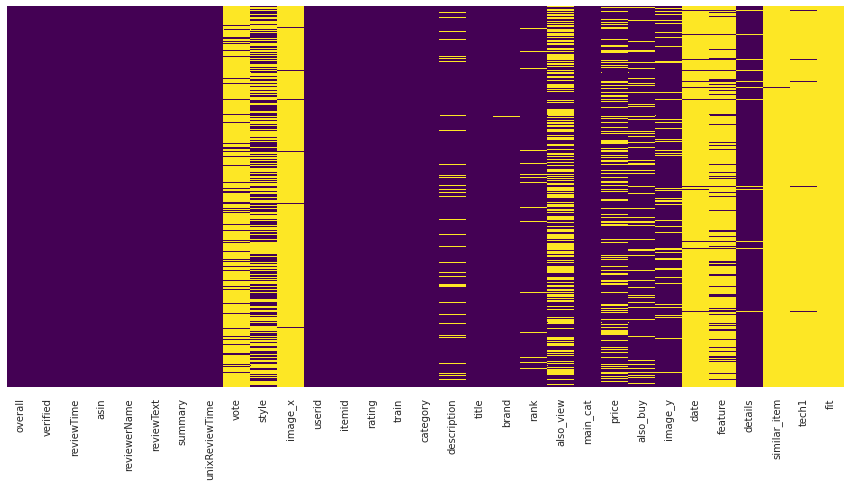

In [16]:
# посмотрим на все значения NAN
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [17]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
asin                    0
reviewerName          211
reviewText            274
summary               166
unixReviewTime          0
vote               959447
style              537955
image_x           1105506
userid                  0
itemid                  0
rating                  0
train                   0
category                0
description         94669
title                   0
brand                8190
rank                46705
also_view          512884
main_cat             1289
price              338374
also_buy           160014
image_y            120333
date              1099233
feature            925801
details             18888
similar_item      1113356
tech1             1109102
fit               1114900
dtype: int64

Описание полученного датасета:

- overall - оценка, которую поставил пользователь (значения от 1 до 5), пропусков 0
- verified - признак верификации пользователя (значения True или False), пропусков 0
- reviewTime - дата отзыва, пропусков 0
- asin - стандартный идентификационный номер Amazon: он состоит из десяти символов (буквы и цифры), пропусков 0
- reviewerName - имя пользователя, пропусков 168
- reviewText - текст отзыва, пропусков 278
- summary - резюме отзыва, пропусков 167
- unixReviewTime - дата отзыва в формате unix
- vote - количество проголосовавших людей за отзыв, очень много пропусков - 728 732
- style - описание размера товара в упаковке и пр., пропусков 407 242
- image - изображение продукта, у большинства продуктов нет картинки
- userid - id пользователя, пропусков 0
- itemid - id товара, пропусков 0
- rating - согласно условий: если человек поставил оценку продукту 4 и больше, то считаем, что продукт понравился, если меньше 4, то продукт не понравился
- train - делим датасет на тестовый и тренировочный
- category - категории в которым относится товар, пропусков 0
- description - описание товара, пропусков 71 495
- title - наименование товара, пропусков 0
- brand - производитель, пропусков 0
- rank - ранг товара в метаданных, пропусков 34 598
- also_view - asin коды товаров, которые также просматриваются с товаром, очень много пропусков
- main_cat - основная категория, к которой относится товар, пропусков 955
- price - цена товара, пропусков 258 621
- also_buy -  asin коды товаров, которые также покупаются с товаром, пропусков - 120 735
- image_y - картинка товара, пропусков 92 239
- date - вероятно дата добавления товара в метаданные, очень много пропусков
- feature - характеристики товара, очень много пропусков
- details - детали, вся информация о товаре, пропусков 14 608
- similar_item, tech1, fit - столбцы в которых почти отсутствуют данные, отправим их на удаление

1. reviewTime и unixReviewTime имеют одни и те же значения, но unixReviewTime имеет более удобный для нас формат, поэтому можем удалить reviewTime;
2. date имеет очень много пропусков, думаю это поле можно удалить
3. feature, details, similar_item, tech1, fit - почти пустые поля, пока можем их удалить

остальные поля рассмотрим более внимательно и по отдельности

In [18]:
df = df.drop(columns = ['reviewTime','feature','details','similar_item','tech1','fit'])

 ## EDA - разведовательный анализ данных

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 25 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1114900 non-null  float64
 1   verified        1114900 non-null  bool   
 2   asin            1114900 non-null  object 
 3   reviewerName    1114689 non-null  object 
 4   reviewText      1114626 non-null  object 
 5   summary         1114734 non-null  object 
 6   unixReviewTime  1114900 non-null  int64  
 7   vote            155453 non-null   object 
 8   style           576945 non-null   object 
 9   image_x         9394 non-null     object 
 10  userid          1114900 non-null  int64  
 11  itemid          1114900 non-null  int64  
 12  rating          1114900 non-null  float64
 13  train           1114900 non-null  int64  
 14  category        1114900 non-null  object 
 15  description     1020231 non-null  object 
 16  title           1114900 non-null  ob

Количество пропусков: 0,
count    1.114900e+06
mean     3.300791e+00
std      2.145678e+00
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64,
Распределение:
5.0    593572
0.0    285965
4.0    109593
3.0     58648
1.0     36368
2.0     30754
Name: overall, dtype: int64,


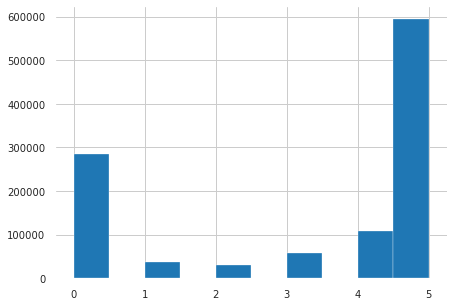

In [20]:
# OVERALL
colInfo(df.overall)

In [21]:
# cудя по всему это итоговая оценка пользователя, шкала от "1" до "5". "0" это значение присоенное тестовому датасету.
# Значение "5" преобладает, пропусков нет. В тестовом файле этого поля нет, тк от него напрямую зависит рейтинг, удалим это поле.
df = df.drop(columns = ['overall'])

Количество пропусков: 0,
count    1.114900e+06
mean     8.686277e-01
std      3.378072e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: verified, dtype: float64,
Распределение:
1    968433
0    146467
Name: verified, dtype: int64,


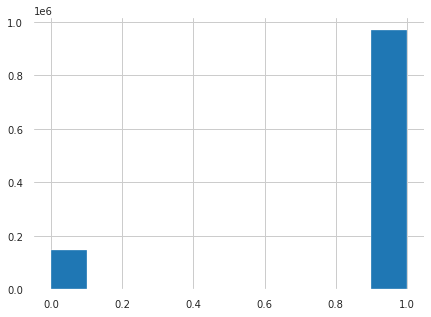

In [22]:
#VERIFIED
# поменяем булевый признак на значения "1" и "0"
df['verified'] = df['verified'].map({True:1, False:0})
colInfo(df.verified)

In [23]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_verified = df.groupby(['rating', 'verified'])['rating'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'рейтинг в разрезе верификации')

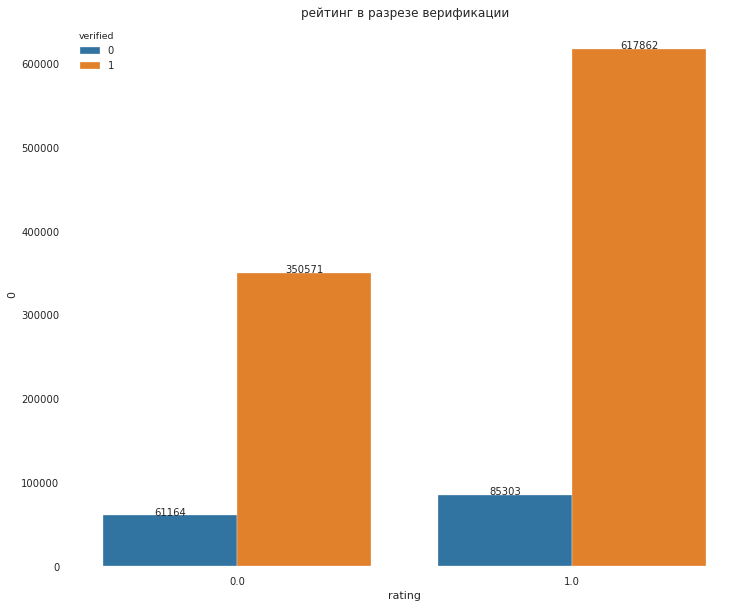

In [24]:
plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x='rating', y=0, hue='verified', data=rating_verified)
show_values_on_bars(ax, 'v')
plt.title('рейтинг в разрезе верификации')
plt.show()

количество верифицированных клиентов выше и у верифицированных клиентов рейтинг все-таки выше.
по хорошему лучше удалить из датасета не верифицированные отзывы, сделаем позже и понаблюдаем. Пропусков нет, оставим пока признак как есть.

In [25]:
#ASIN
df.asin.describe()
df.asin.isnull().sum()

count        1114900
unique         41320
top       B00BUKL666
freq            7326
Name: asin, dtype: object

0

как видно уникальных товаров только 41320, значит товары у нас повторяются, пустых значений нет, оставим как есть, идем дальше

In [26]:
# REVIEWERNAME
df.reviewerName.describe()
df.reviewerName.value_counts()
df.reviewerName.isnull().sum()

count             1114689
unique             101473
top       Amazon Customer
freq                41309
Name: reviewerName, dtype: object

Amazon Customer     41309
Kindle Customer      8086
Linda                 967
John                  920
David                 786
                    ...  
eeMac                   1
melissa e thomas        1
Kari K. Binner          1
Francis Shirey          1
Carina Johnsson         1
Name: reviewerName, Length: 101473, dtype: int64

211

In [27]:
# слишком большое количество пользовательских имен, выделить определенных пользователей (типа клиентов амазон, киндэла...) возможно имеет смысл, но пока просто удалим
df = df.drop(columns = ['reviewerName'])

In [28]:
# REVIEWTEXT #SUMMARY
# в целом я хотела выделить топ 30-50 часто встречающихся слов и разгетдамить их, но тк этих данных нет в тестовом датасете, приняла решение удалить эти признаки

# обработав текст, загрузим словарик с 50 часто встречающимися словами
#dict_words=pd.read_csv('../input/dictionary')
# создадим каждый новый признак на основании значений в часто встречающихся словах, ну и удалим поле с текстом после
#for i in dict_words.words.to_list():
#    df[i] = 0
#for j in dict_words.words.to_list():
#    df.loc[df.summary.str.contains(j, regex=False), j] = 1
df = df.drop(columns = ['reviewText','summary'])

In [29]:
# UNIXREVIEWTIME
# приведем дату отзыва в более удобный вид и добавим поле "year", в каком году был написан отзыв:
df['date'] = df['unixReviewTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
df['year'] = df['unixReviewTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y'))

Количество пропусков: 0,
count     1114900
unique         18
top          2016
freq       247590
Name: year, dtype: object,
Распределение:
2016    247590
2015    239733
2017    199215
2014    161227
2018     97195
2013     87795
2012     33387
2011     19280
2010     11180
2009      8942
2008      5400
2007      2981
2006       865
2005        80
2004        23
2003         4
2002         2
2000         1
Name: year, dtype: int64,


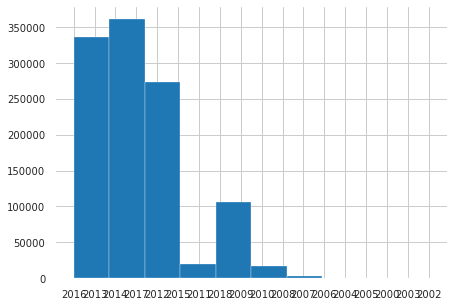

In [30]:
colInfo(df.year)

In [31]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_year = df[df.train==1].groupby(['year', 'rating'])['year'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'рейтинг в разрезе годов')

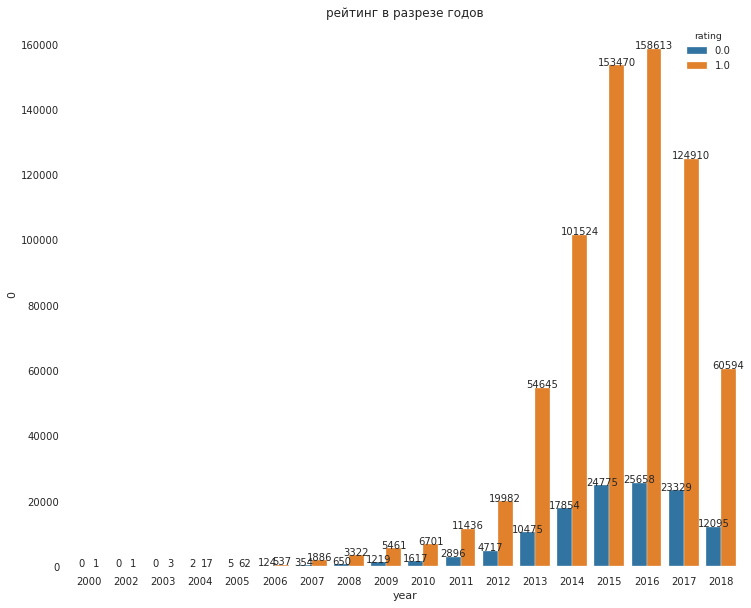

In [32]:
plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x='year', y=0, hue='rating', data=rating_year)
show_values_on_bars(ax, 'v')
plt.title('рейтинг в разрезе годов')
plt.show()

учет отзывов ведется с 2000 года, пик пришелся на 2016 год, до этого года шел стремительный рост, а после 2016 год наблюдается спад интереса и показатели 2018 сравнимы с показателями 2013 года.

Text(0.5, 1.0, 'зависимость рейтинга от времени')

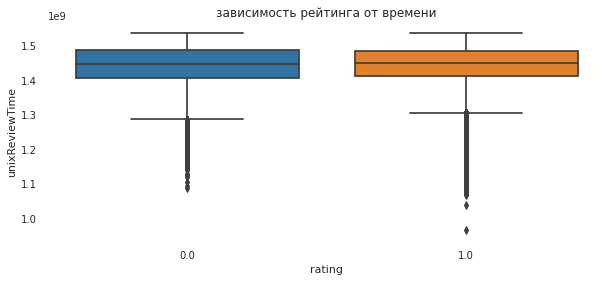

In [33]:
fig,ax=plt.subplots(figsize=(10,4))
sns.boxplot(y='unixReviewTime',x='rating', data=df[df.train==1])
plt.title('зависимость рейтинга от времени')
plt.show()

In [34]:
#VOTE
df.vote.isna().sum()

959447

очень много отзывов без голоса, думаю можно создать признак 1/0 - головали либо же не голосовали, не зависимо от количества

In [35]:
df['vote'] = df['vote'].apply(lambda x: 0 if isnull(x) else 1)

Количество пропусков: 0,
count    1.114900e+06
mean     1.394322e-01
std      3.463972e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: vote, dtype: float64,
Распределение:
0    959447
1    155453
Name: vote, dtype: int64,


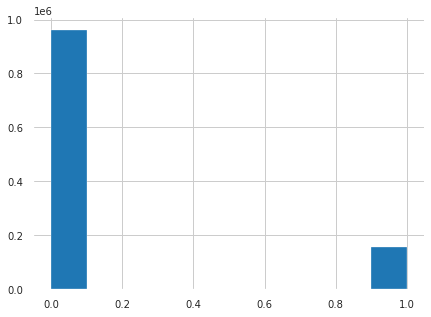

In [36]:
colInfo(df.vote)

Text(0.5, 1.0, 'рейтинг в разрезе голосов')

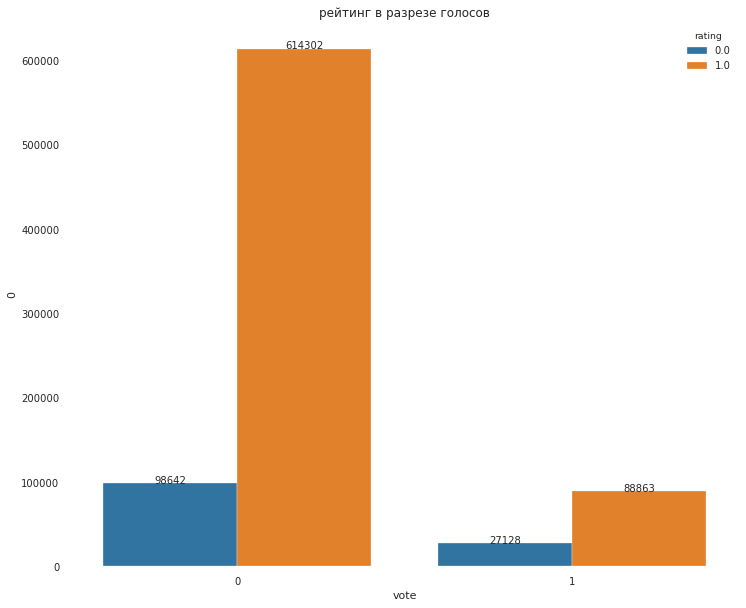

In [37]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_vote= df[df.train==1].groupby(['vote', 'rating'])['vote'].count().unstack().fillna(0).unstack().reset_index()

plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x='vote', y=0, hue='rating', data=rating_vote)
show_values_on_bars(ax, 'v')
plt.title('рейтинг в разрезе голосов')
plt.show()

судя по всему распределение рейтинга не зависит особо от голосов, пока оставим как есть

In [38]:
# STYLE
# данное поле показывает размер упаковки, кол-во штук в товаре
df['style'].describe()
df['style'].isnull().sum()

count                      576945
unique                      27582
top       {'Size:': ' Pack of 1'}
freq                         6408
Name: style, dtype: object

537955

довольно много пропусков, заменим пустые значения на "0", по остальным проставим "1" и посмотрим влияет ли наличие описание размера/кол-во шт в упаковке на рейтинг

In [39]:
df['style'] = df['style'].apply(lambda x: 0 if isnull(x) else 1)

Text(0.5, 1.0, 'влияние описание упаковки на рейтинг')

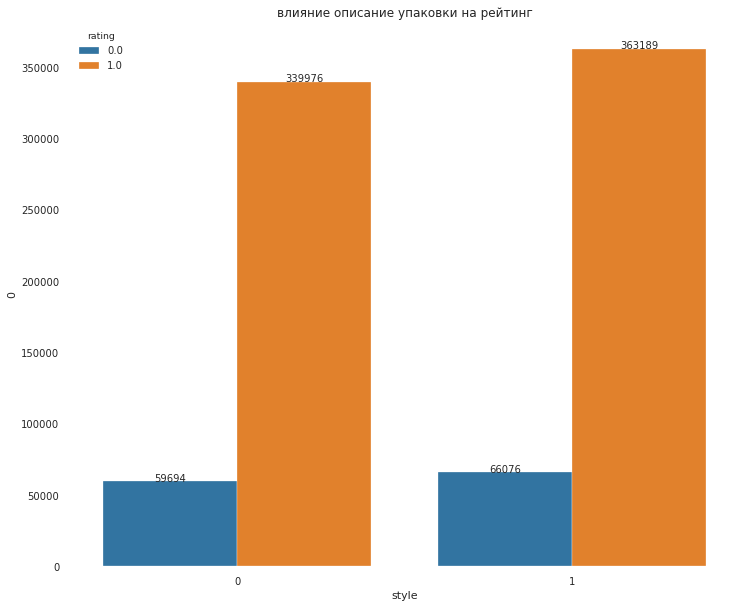

In [40]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_style= df[df.train==1].groupby(['style', 'rating'])['style'].count().unstack().fillna(0).unstack().reset_index()

plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x='style', y=0, hue='rating', data=rating_style)
show_values_on_bars(ax, 'v')
plt.title('влияние описание упаковки на рейтинг')
plt.show()

рейтинг не намного выше у товаров имеющих описание упаковки, оставим пока как есть

In [41]:
#IMAGE_X #IMAGE_Y
#проделаем тоже самое и с картинками  и посмотрим влияет ли наличие картинок на рейтинг

In [42]:
df['image'] = df['image_x'].apply(lambda x: 0 if isnull(x) else 1)

In [43]:
df.loc[~df.image_y.isnull(),'image'] = 1

In [44]:
df.image.value_counts()

1    995397
0    119503
Name: image, dtype: int64

In [45]:
df = df.drop(columns = ['image_x','image_y'])

Text(0.5, 1.0, 'влияние наличия картинки на рейтинг')

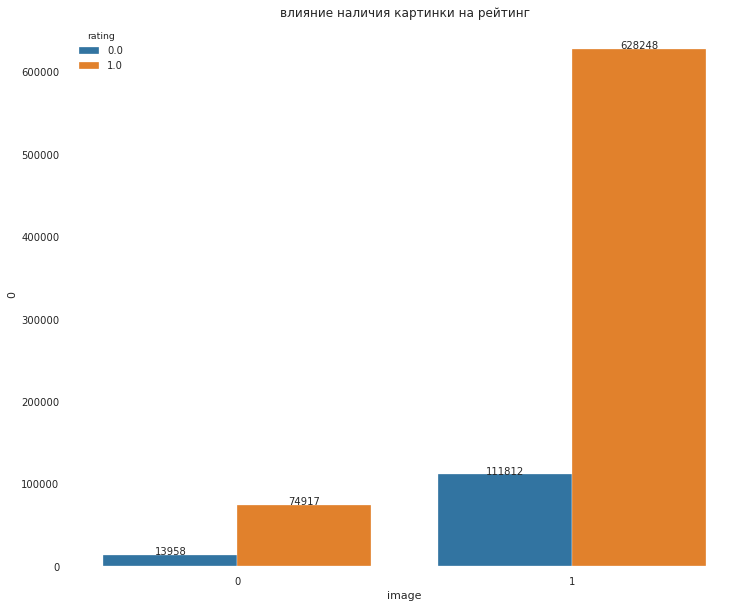

In [46]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_image = df[df.train==1].groupby(['image', 'rating'])['image'].count().unstack().fillna(0).unstack().reset_index()

plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x='image', y=0, hue='rating', data=rating_image)
show_values_on_bars(ax, 'v')
plt.title('влияние наличия картинки на рейтинг')
plt.show()

Наличие картинки довольно сильно влияет на рейтинг, оставим признак, будем наблюдать

In [47]:
# USERID #ITEMID
# пропусков нет, к идентификаторам добавить нечего

#RATING
# про рейтинг уже описывала, на тесте у нас стоит значение "0", тк именно этот признак нам нужно предсказать

#CATEGORY #MAIN_CAT
print(df.category[500])
print(df.main_cat[500])

['Grocery & Gourmet Food', 'Jams, Jellies & Sweet Spreads', 'Nut & Seed Butters', 'Peanut Butter']
Grocery


In [48]:
# считаю что основной категории будет достаточно для создания дамми-переменных, категорию удалим
df.main_cat.value_counts()

Grocery                      1055102
Health & Personal Care         42908
Amazon Home                     9324
All Beauty                      1962
Sports & Outdoors               1489
Industrial & Scientific         1225
Office Products                  843
Toys & Games                     402
Pet Supplies                     169
Tools & Home Improvement          74
Baby                              50
Arts, Crafts & Sewing             25
Home Audio & Theater              11
Camera & Photo                     9
Musical Instruments                8
Software                           5
Cell Phones & Accessories          5
Name: main_cat, dtype: int64

In [49]:
df = df.drop(columns = ['category'])

In [50]:
# пустые значения заменим самым часто встречающимся значением
df.loc[df.main_cat.isna(),'main_cat'] = 'Grocery'

Text(0.5, 1.0, 'рейтинг в разрезе категорий')

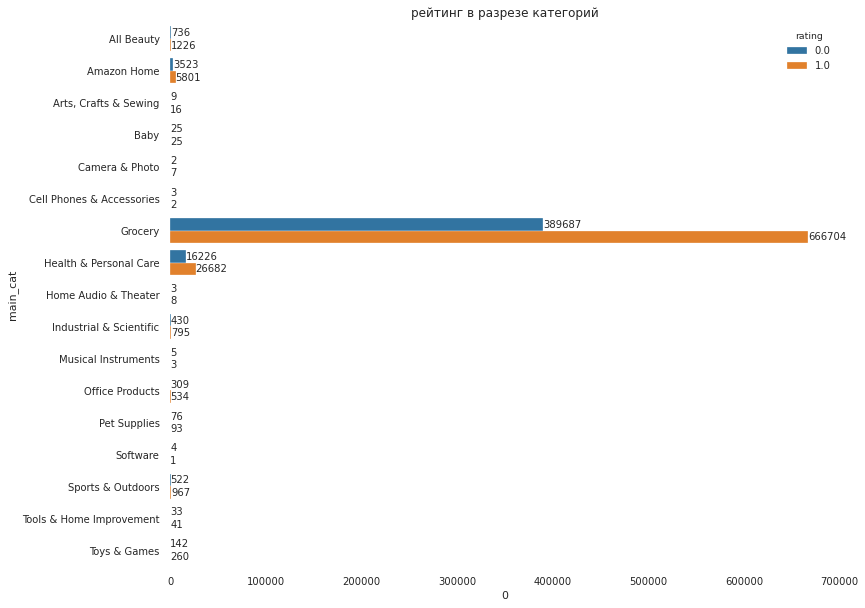

In [51]:
#группируем данные, преобразоваваем, чтобы не было потерь в NAN
rating_by_cat = df.groupby(['main_cat', 'rating'])['main_cat'].count().unstack().fillna(0).unstack().reset_index()

plt.rcParams['figure.figsize']=12,10
ax = sns.barplot(x=0, y='main_cat', hue='rating', data=rating_by_cat)
show_values_on_bars(ax, 'h')
plt.title('рейтинг в разрезе категорий')
plt.show()

самые популярные категории "Grocery" и "Health&Personal care" ну это понятно, теперь понятно почему было много пользователей Амазон, здесь отдельная статья "Amazon Home"

Количество пропусков: 0,
count     1114900
unique         17
top       Grocery
freq      1056391
Name: main_cat, dtype: object,
Распределение:
Grocery                      1056391
Health & Personal Care         42908
Amazon Home                     9324
All Beauty                      1962
Sports & Outdoors               1489
Industrial & Scientific         1225
Office Products                  843
Toys & Games                     402
Pet Supplies                     169
Tools & Home Improvement          74
Baby                              50
Arts, Crafts & Sewing             25
Home Audio & Theater              11
Camera & Photo                     9
Musical Instruments                8
Software                           5
Cell Phones & Accessories          5
Name: main_cat, dtype: int64,


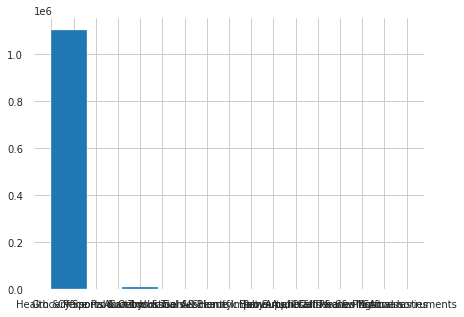

In [52]:
colInfo(df.main_cat)

In [53]:
#DESCRIPTION #TITLE #BRAND
#дропну признаки, тк в первом содержаться данные и второго и третьего поля, в целом можно было бы вытащить чатсо встречающиеся значения, 
# но не вижу смыcла, тк они и так поеделены на категории
df = df.drop(columns = ['description','title','brand'])

In [54]:
#RANK
df['rank'][40]

'171,325inGroceryGourmetFood('

In [55]:
#выделим только цифровые значения
# Приведем все к str
df['rank'] = df['rank'].astype('str')
# Удалим все значения кроме числовых
df['rank'] = df['rank'].apply(lambda x: re.sub('\D', '', x))

In [56]:
# Избавимся от пустых значений
df['rank'] = df['rank'].apply(lambda x: 0 if x == '' else x)

In [57]:
df['rank'] = df['rank'].astype('float')

In [58]:
#ALSOVIEW #ALSOBUY
# Проделаем тоже самое что и с картинками:

In [59]:
df.loc[~df.also_buy.isnull(),'also_buy'] = 1
df.loc[df.also_buy.isnull(),'also_buy'] = 0

In [60]:
df.loc[~df.also_view.isnull(),'also_view'] = 1
df.loc[df.also_view.isnull(),'also_view'] = 0

In [61]:
df.also_buy.describe()
df.also_view.describe()

count     1114900
unique          2
top             1
freq       954886
Name: also_buy, dtype: int64

count     1114900
unique          2
top             1
freq       602016
Name: also_view, dtype: int64

In [62]:
df.also_view = df.also_view.astype('int')
df.also_buy = df.also_buy.astype('int')
df.year = df.year.astype(int)

Количество пропусков: 338374,
count     776526
unique      4603
top       $14.99
freq       18838
Name: price, dtype: object,
Распределение:
$14.99     18838
$13.67     14307
$19.99     12059
$14.79      7539
$15.53      7308
           ...  
$80.70         3
$264.87        2
$49.06         2
$6.93          1
$275.00        1
Name: price, Length: 4603, dtype: int64,


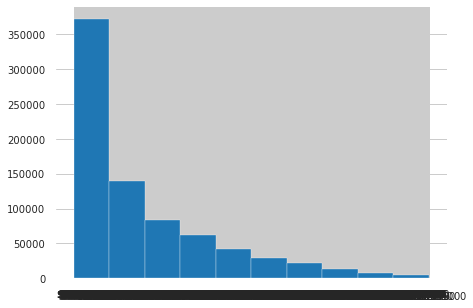

In [63]:
#PRICE
colInfo(df.price)

In [64]:
# У нас довольно много пропусков и есть диапозоны цен. Заменим такие значения и пропуски на среднее значение. 
# Cоздадим вспомогательный датасет, удалим в нем пропуски в столбце price и посчитаем среднее.
# Скопируем датасет
# Приведем все к str
df['price'] = df['price'].astype('str')
# Удалим все значения кроме числовых
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))

In [65]:
#Чтобы найти среднее значение нужно посчитать все значения без пропусков
# Скопируем датасет
df_price = df.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Переведем во float
df_price['price'] = df_price['price'].astype('float')

Количество пропусков: 0,
count    739046.000000
mean       1874.356174
std         975.457068
min           1.000000
25%        1149.000000
50%        1624.000000
75%        2473.000000
max        4796.000000
Name: price, dtype: float64,
Распределение:
1499.0    18838
1367.0    14307
1999.0    12059
1479.0     7539
1553.0     7308
          ...  
3161.0        4
2752.0        4
3926.0        4
4612.0        4
693.0         1
Name: price, Length: 3806, dtype: int64,


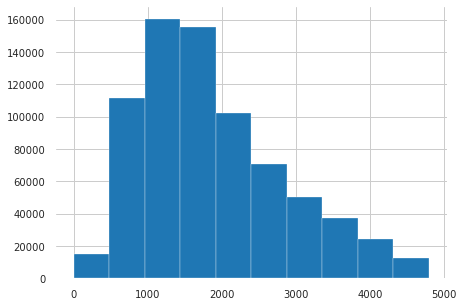

In [66]:
#посмотрим на выбросы
    
perc25 = df_price['price'].quantile(0.25)
perc75 = df_price['price'].quantile(0.75)
IQR = perc75 - perc25
up = perc75 + 1.5*IQR
# Удалим выбросы т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < up]
# Посмотрим на результат
colInfo(df_price.price)

In [67]:
price_mean = df_price.price.mean()
price_mean

1874.3561740405873

Количество пропусков: 0,
count    1.114900e+06
mean     5.397482e+05
std      1.138860e+07
min      1.000000e+00
25%      1.399000e+03
50%      1.874000e+03
75%      2.184000e+03
max      5.499816e+08
Name: price, dtype: float64,
Распределение:
1874     338553
1499      18838
1367      14307
1999      12059
1479       7539
          ...  
8070          3
26487         2
4906          2
27500         1
693           1
Name: price, Length: 4603, dtype: int64,


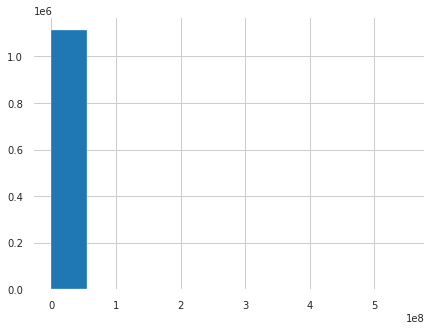

In [68]:
# Заменим пропуски на среднее значение
df['price'] = df['price'].apply(lambda x: round(price_mean, 0) if x == '' else x)
# Приведем к float
df['price'] = df['price'].astype('float')
# Приведем к int32
df['price'] = df['price'].astype('int32')
# Смотрим на результат
colInfo(df.price)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   verified        1114900 non-null  int64  
 1   asin            1114900 non-null  object 
 2   unixReviewTime  1114900 non-null  int64  
 3   vote            1114900 non-null  int64  
 4   style           1114900 non-null  int64  
 5   userid          1114900 non-null  int64  
 6   itemid          1114900 non-null  int64  
 7   rating          1114900 non-null  float64
 8   train           1114900 non-null  int64  
 9   rank            1114900 non-null  float64
 10  also_view       1114900 non-null  int64  
 11  main_cat        1114900 non-null  object 
 12  price           1114900 non-null  int32  
 13  also_buy        1114900 non-null  int64  
 14  date            1114900 non-null  object 
 15  year            1114900 non-null  int64  
 16  image           1114900 non-null  in

In [70]:
df.columns

Index(['verified', 'asin', 'unixReviewTime', 'vote', 'style', 'userid',
       'itemid', 'rating', 'train', 'rank', 'also_view', 'main_cat', 'price',
       'also_buy', 'date', 'year', 'image'],
      dtype='object')

## Корреляционный анализ

In [71]:
for col in ['verified', 'asin', 'unixReviewTime', 'vote', 'style', 'userid','itemid', 'rating', 'train', 'rank', 'also_view', 'main_cat', 'price','also_buy', 'date', 'year', 'image']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки style
Найдены статистически значимые различия для колонки userid
Найдены статистически значимые различия для колонки rating
Найдены статистически значимые различия для колонки train
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки also_view
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price
Найдены статистически значимые различия для колонки also_buy
Найдены статистически значимые различия для колонки year
Найдены статистически значимые различия для колонки image


<Figure size 936x504 with 0 Axes>

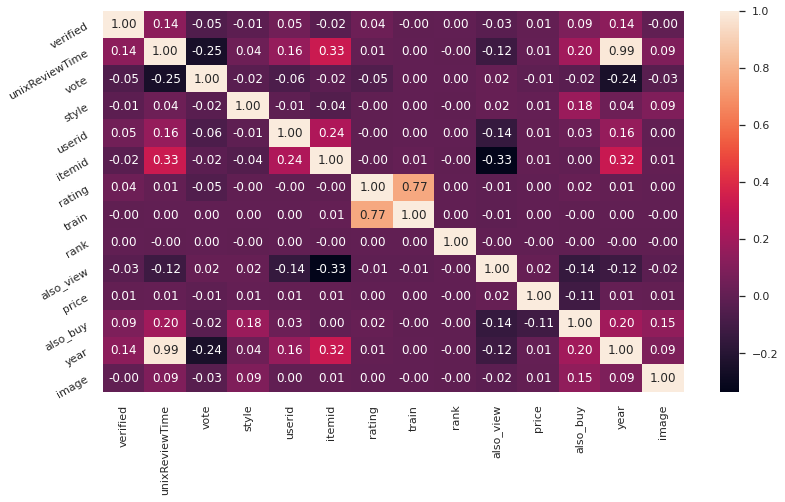

In [72]:
#посмотрим на корреляцию признаков
corr = df.corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

сильно коррелируют дата ревью и год, это понятно. Также вижу сильную корреляцию рейтинга и признака "train" здесь тоже все понятно. Пока оставим как есть

## Разбиение выборки

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   verified        1114900 non-null  int64  
 1   asin            1114900 non-null  object 
 2   unixReviewTime  1114900 non-null  int64  
 3   vote            1114900 non-null  int64  
 4   style           1114900 non-null  int64  
 5   userid          1114900 non-null  int64  
 6   itemid          1114900 non-null  int64  
 7   rating          1114900 non-null  float64
 8   train           1114900 non-null  int64  
 9   rank            1114900 non-null  float64
 10  also_view       1114900 non-null  int64  
 11  main_cat        1114900 non-null  object 
 12  price           1114900 non-null  int32  
 13  also_buy        1114900 non-null  int64  
 14  date            1114900 non-null  object 
 15  year            1114900 non-null  int64  
 16  image           1114900 non-null  in

In [74]:
df['rank'] = df['rank'].astype(int)

## попробуем для начала catboost

In [75]:
X = df[df.train==1].drop(['rating'], axis=1)
y = df[df.train==1].rating.values
X.shape

(828935, 16)

In [76]:
X_sub=df[df.train==0].drop(['rating'], axis=1)
X_sub.shape

(285965, 16)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=47)

In [78]:
cat_features=X.columns
cat_features

Index(['verified', 'asin', 'unixReviewTime', 'vote', 'style', 'userid',
       'itemid', 'train', 'rank', 'also_view', 'main_cat', 'price', 'also_buy',
       'date', 'year', 'image'],
      dtype='object')

In [79]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.8, random_state=47)
    train_pool = Pool(train_x, train_y, cat_features=cat_features)
    test_pool = Pool(test_x, test_y, cat_features=cat_features)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 980),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    ROC = sklearn.metrics.roc_auc_score(test_y, pred_labels)
    return ROC

In [80]:
from catboost import CatBoostRegressor
import optuna

In [81]:
if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=2)
    #print(study.best_trial)

0:	learn: 0.3594103	total: 185ms	remaining: 25.7s
1:	learn: 0.3593251	total: 280ms	remaining: 19.3s
2:	learn: 0.3592965	total: 345ms	remaining: 15.8s
3:	learn: 0.3592341	total: 410ms	remaining: 13.9s
4:	learn: 0.3591238	total: 481ms	remaining: 13s
5:	learn: 0.3590547	total: 541ms	remaining: 12.1s
6:	learn: 0.3589832	total: 589ms	remaining: 11.2s
7:	learn: 0.3589808	total: 624ms	remaining: 10.3s
8:	learn: 0.3589196	total: 682ms	remaining: 9.93s
9:	learn: 0.3588884	total: 718ms	remaining: 9.34s
10:	learn: 0.3588244	total: 764ms	remaining: 8.96s
11:	learn: 0.3587539	total: 822ms	remaining: 8.77s
12:	learn: 0.3586307	total: 884ms	remaining: 8.63s
13:	learn: 0.3584954	total: 942ms	remaining: 8.48s
14:	learn: 0.3584563	total: 1s	remaining: 8.38s
15:	learn: 0.3583767	total: 1.07s	remaining: 8.3s
16:	learn: 0.3583087	total: 1.11s	remaining: 8.07s
17:	learn: 0.3582500	total: 1.19s	remaining: 8.04s
18:	learn: 0.3582393	total: 1.22s	remaining: 7.74s
19:	learn: 0.3582147	total: 1.27s	remaining: 7.

[I 2021-01-05 17:48:24,708] Finished trial#0 with value: 0.5 with parameters: {'iterations': 140, 'depth': 6, 'learning_rate': 0.02141371774060793, 'random_strength': 44, 'bagging_temperature': 0.026096137229638914, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial#0 with value: 0.5.


0:	learn: 0.3593730	total: 191ms	remaining: 42.2s
1:	learn: 0.3593134	total: 285ms	remaining: 31.3s
2:	learn: 0.3593133	total: 349ms	remaining: 25.5s
3:	learn: 0.3592743	total: 685ms	remaining: 37.3s
4:	learn: 0.3592695	total: 850ms	remaining: 36.9s
5:	learn: 0.3592292	total: 883ms	remaining: 31.8s
6:	learn: 0.3592028	total: 1.16s	remaining: 35.5s
7:	learn: 0.3590823	total: 1.58s	remaining: 42.3s
8:	learn: 0.3589610	total: 1.81s	remaining: 43s
9:	learn: 0.3588178	total: 2.25s	remaining: 47.8s
10:	learn: 0.3586875	total: 2.72s	remaining: 52.2s
11:	learn: 0.3584150	total: 3.15s	remaining: 55.1s
12:	learn: 0.3583570	total: 3.28s	remaining: 52.7s
13:	learn: 0.3582512	total: 3.67s	remaining: 54.6s
14:	learn: 0.3581079	total: 4.09s	remaining: 56.5s
15:	learn: 0.3580390	total: 4.58s	remaining: 58.9s
16:	learn: 0.3579814	total: 4.91s	remaining: 59.2s
17:	learn: 0.3579356	total: 5.03s	remaining: 57.1s
18:	learn: 0.3579269	total: 5.41s	remaining: 57.8s
19:	learn: 0.3578506	total: 5.7s	remaining:

[I 2021-01-05 17:49:43,649] Finished trial#1 with value: 0.5009181009223671 with parameters: {'iterations': 222, 'depth': 10, 'learning_rate': 0.04694158617503351, 'random_strength': 91, 'bagging_temperature': 0.4344919531062362, 'od_type': 'Iter', 'od_wait': 50}. Best is trial#0 with value: 0.5.


In [82]:
study.best_params

{'iterations': 140,
 'depth': 6,
 'learning_rate': 0.02141371774060793,
 'random_strength': 44,
 'bagging_temperature': 0.026096137229638914,
 'od_type': 'IncToDec',
 'od_wait': 36}

In [83]:
# Посмотрим как ведет себя модель и подготовим признаки на исключение
model = CatBoostRegressor(iterations=800,
                          learning_rate=0.0535,
                          depth=7,
                          random_state=47,
                          random_strength=3,
                          bagging_temperature=96.8,
                          eval_metric='AUC',
                          custom_metric=['RMSE', 'R2'],
                          od_type='IncToDec',
                          od_wait=42,
                          #od_pval=0.002,
                          #l2_leaf_reg=1,
                          #subsample=0.75
                         )

model.fit(X_train, y_train,
         cat_features=cat_features, 
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7288006	best: 0.7288006 (0)	total: 1.2s	remaining: 16m 1s
100:	test: 0.7626192	best: 0.7626192 (100)	total: 1m 38s	remaining: 11m 18s
200:	test: 0.7652150	best: 0.7652150 (200)	total: 3m 35s	remaining: 10m 41s
300:	test: 0.7672637	best: 0.7672637 (300)	total: 5m 39s	remaining: 9m 22s
400:	test: 0.7686779	best: 0.7686779 (400)	total: 7m 37s	remaining: 7m 35s
500:	test: 0.7695081	best: 0.7695081 (500)	total: 9m 45s	remaining: 5m 49s
600:	test: 0.7699882	best: 0.7699882 (600)	total: 11m 55s	remaining: 3m 56s
700:	test: 0.7703091	best: 0.7703114 (697)	total: 14m 8s	remaining: 1m 59s
799:	test: 0.7706331	best: 0.7706331 (799)	total: 16m 20s	remaining: 0us

bestTest = 0.770633101
bestIteration = 799



In [84]:
predict_submission = model.predict(X_sub)
predict_submission

array([0.9287031 , 0.86434055, 0.90329157, ..., 0.81356369, 0.85481712,
       0.97204315])

In [85]:
submission['rating']= predict_submission

In [86]:
submission.to_csv('submission_cat.csv', index=False)

## теперь попробуем LightFM в чистом виде, без добавления фичей

In [87]:
train = df[df.train==1]
test = df[df.train==0]

In [88]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [89]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [90]:
def lightfm_objective(trial):
    param = {
        'loss': trial.suggest_categorical('loss', ['warp']),
        'no_components': trial.suggest_int('no_components', 10, 300, 10),
        #'epochs': trial.suggest_uniform('epochs', 10, 100), 
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-7, 1e-2),
        'user_alpha': trial.suggest_loguniform('user_alpha', 1e-9, 1e-0),
        'item_alpha': trial.suggest_loguniform('item_alpha', 1e-9, 1e-0),
        'k': trial.suggest_int('k', 5, 10, 1),
        'n': trial.suggest_int('n', 5, 20, 1),
        'max_sampled': trial.suggest_int('max_sampled', 5, 30, 5)

    }

    lightfm_model = LightFM(**param)

    lightfm_model.fit(
        ratings_coo,
        #interactions=train_interactions,
        #user_features=user_features,
        #item_features=item_features,
        #sample_weight=train_weights,
        num_threads=4, 
        verbose=True)

    preds = lightfm_model.predict(test_data.userid.values,test_data.itemid.values)
    ROC = sklearn.metrics.roc_auc_score(test_data.rating,preds)
    return ROC


if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(lightfm_objective, n_trials=5, n_jobs=-1)

Epoch 0
Epoch 0
Epoch 0
Epoch 0


[I 2021-01-05 18:06:39,284] Finished trial#2 with value: 0.5152770125814529 with parameters: {'loss': 'warp', 'no_components': 100, 'learning_rate': 0.008806690566695067, 'user_alpha': 0.01739039030759426, 'item_alpha': 0.000269858989299601, 'k': 6, 'n': 12, 'max_sampled': 15}. Best is trial#2 with value: 0.5152770125814529.


Epoch 0


[I 2021-01-05 18:06:40,794] Finished trial#3 with value: 0.5260565611315098 with parameters: {'loss': 'warp', 'no_components': 110, 'learning_rate': 0.009049861504201059, 'user_alpha': 6.720873125691361e-08, 'item_alpha': 6.7324505924973064e-06, 'k': 10, 'n': 7, 'max_sampled': 10}. Best is trial#2 with value: 0.5152770125814529.
[I 2021-01-05 18:06:42,516] Finished trial#1 with value: 0.5270349799111207 with parameters: {'loss': 'warp', 'no_components': 160, 'learning_rate': 0.0044205463996839596, 'user_alpha': 4.531056826904695e-07, 'item_alpha': 5.421090154760185e-08, 'k': 6, 'n': 17, 'max_sampled': 15}. Best is trial#2 with value: 0.5152770125814529.
[I 2021-01-05 18:06:43,314] Finished trial#4 with value: 0.5412682556286 with parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.0015558683353631667, 'user_alpha': 0.1561266661424839, 'item_alpha': 1.220593009002527e-05, 'k': 10, 'n': 7, 'max_sampled': 20}. Best is trial#2 with value: 0.5152770125814529.
[I 2021-01-05 

In [91]:
study.best_params

{'loss': 'warp',
 'no_components': 100,
 'learning_rate': 0.008806690566695067,
 'user_alpha': 0.01739039030759426,
 'item_alpha': 0.000269858989299601,
 'k': 6,
 'n': 12,
 'max_sampled': 15}

In [92]:
# обучим модель
LR = 0.007
NUM_THREADS = 12 #число потоков
NUM_COMPONENTS = 300 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LOSS_FUNCTION = 'warp'
RANDOM_STATE = 47

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    random_state = RANDOM_STATE
)
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [93]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)


In [94]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.5738019203726145

не плохо, но катбуст показал лучше результат

In [95]:
preds = model.predict(test.userid.values,
                      test.itemid.values)


In [96]:
preds.min(), preds.max()

(-3.525120973587036, 9.407011985778809)

In [97]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()


In [98]:
normalized_preds.min(), normalized_preds.max()


(0.0, 1.0)

In [99]:
submission['rating']= normalized_preds

In [100]:
submission.to_csv('submission_log.csv', index=False)

теперь попробуем решить проблему холодного старта:
    
нужно вызвать метод fit, чтобы сообщить LightFM id пользователей, id продуктов, и дополнительные фичи пользователя или продукта.

Мы передадим методу fit три параметра:

users: список всех пользователей
items: список всех продуктов
item_features: список дополнительных фичей продукта

Передача списка пользователей и продуктов довольно проста - просто используем столбцы «userid» и «itemid» из df.

Когда дело доходит до передачи item_features, передаем список, в котором каждый элемент имеет формат, подобный 'feature_name: feature_value'.

С помощью добавления item_features и user_features, появляется возможность обойти проблему холодного старта. 

Мы можем получить информацию о пользователе, например, при регистрации, и использовать эти данные для получения рекомендаций.

In [101]:
#Формируем списки Id для пользователей и продуктов
train = generate_int_id(train, 'userid_1')
train = generate_int_id(train, 'itemid_1')

#добавим только одну фичу, тк все виснет
list_item_features =['price'] 

# создание признаков для передачи в алгоритм
train['item_features'] = create_features(train, list_item_features, 'itemid_1')

# генерация списка признаков
item_feature_list = generate_feature_list(train,list_item_features)

# Построение матрицы через датасет lightfm

dataset = Dataset()
dataset.fit(
    set(train['userid_1']), 
    set(train['itemid_1']),
    user_features=None, 
    item_features=item_feature_list)
 
item_features = dataset.build_item_features(train['item_features'])


In [102]:
# Подготавливаем данных: разбиваем выборку на обучение и тест 
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [103]:
#Обучаем модель
model = LightFM (learning_rate=0.1, 
                loss='logistic',
                learning_schedule= 'adagrad',
                no_components=120)
model = model.fit(ratings_coo, 
                  item_features = item_features,
                  epochs=20,  
                  num_threads=4)

model.item_biases *= 1.0
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values,
                      item_features = item_features)

roc_auc_score(test_data.rating, preds)

0.6842819107782429

In [104]:
item_biases, item_embeddings = model.get_item_representations()

In [105]:
#Сохранение векторных представлений для модели
import pickle
with open('item_embeddings_lfm_comp.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

## Выводы

- Проведен анализ и построена базовая модель, но катбуст показал себя лучше
- Познакомились с основными принципами работы рекомендательных систем
- Добавлены признаки товаров и подобраны гиперпараметры
- Даны рекомендации пользователю на основе эмбеддингов понравившихся товаров
